<a href="https://colab.research.google.com/github/btemperton/dilution_to_extinction/blob/master/DTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelling a Dilution To Extinction Culturing Experiment

In order to grow fastidious bacterial taxa that don't grow on agar, one needs to inoculate a single well of medium with a single cell in order to allow them to grow without competition. Typically, one dilutes natural microbial community down to just an inoculum of few cells per microlitre to be added to each well containing an appropriate medium.

The likelihood of positive growth for a given taxon in a well is a function of how many live and viable cells are placed in the well, $C$.

<br/>
We can calculate $C$ by multiplying the relative abundance of a taxon in a community with the total number of cells in the inoculum. For instance, if we have $10^6\ cells \cdot ml^{-1}$ in our community, as measured by flow cytometry, then we will have on average 1,000 cells in every $\mu L$. Let's say for our inoculum, we aim for an average of $2\ cells \cdot ml^{-1}$, so we dilute by a factor of 500.

<br><br>
If our cells of interest comprise 40% of the community, then the mean number of cells we will be adding per well _of this particular taxon_ will be:
$$
2 \times 0.4 = 0.8
$$

So, for a given taxon $i$, the number of cells within an inoculum will be:

$$
I_{i} = I \cdot p_{i}
$$

where $p_{i}$ is the proportion of the community comprised by taxon $i$ and $I$ is the mean number of cells added per well.

<br><br>
We must also account for the fact that because you can't successfully inoculate a well with fractions of a cell, then the actual number of cells we place in a well will be Poisson distributed, and we should more accurately define $I_{i}$ as the mean number of cells added to a well, $\bar{I_{i}}$. Now, the number of cells added to a well will be defined as the probability mass function

$$
\frac{\bar{I_{i}}^{k}e^{-\bar{I_{i}}}}{k!}
$$
where $k$ is the number of wells inoculated.
<br><br>
However, remember that in order to grow a cell must be *viable*.  Here, we define viability, $V$, as the probability that a cell will grow.

$V$ is a composite of two parameters:
  * The proportion of the cells in a community that are alive
  * The suitability of the growth medium to the enable growth for taxon $i$.

If all the cells within an inoculum are alive, and the medium matches the optimal growth conditions for the taxon, then $V=1$. If the medium is not suitable for growth of the taxon, then the number of cells that are alive becomes irrelevent and $V=0$. Similarly, if the medium is optimal, and the number of cells measured on a flow cytometer is $10^6\ cells \cdot ml^{-1}$, but they are all fixed, then $V=0$

Thus we can define $V$ for a given taxon $i$ as:
$$
V_{i} = a_{i}\cdot s_{i}
$$

where $a_{i}$ is the proportion of cells that are alive for taxon $i$ and $s_{i}$ is the suitability of the medium to support growth of taxon $i$. 

If $V_{i}$ is defined as the probability that it a given cell will grow, then the likelihood of a well showing positive growth is a function of a binomial distribution, where the number of 'trials' is governed by the number of cells inoculated into the well.

Thus, the predicted number of positive wells for a given taxon, $C_{i}$, is determined by the interaction between a Poisson distribution (for inoculum size) and a binomial distribution (for viability).


## Calculating $V_{i}$

Whereas the parameter $I$ is directly measureable, and $p_{i}$ can be calculated from relative abundance data using 16S rRNA amplicons, $V_{i}$ is much trickier to parameterise. We could potentially evaluate $a_{i}$ by performing live/dead staining for the whole community and assume that $a_{i}$ is uniform across the community. Quantifying active cells using methods such as BONCAT-FACS may also provide a similar approximation.
<br><br>
Medium suitability, $s_{i}$ has values from $0 \leq s_{i} \leq 1$, where $s_{i} = 1$ represents a perfect match for optimum medium and $s_{i}=0$ represents a medium that taxon $i$ is unable to grow on. If one assumes that the conditions in which the bacterium is found in nature represents optimal growth medium (a bold assumption, particularly for rare taxa), $s_{i}$ can be approximated as the Euclidian distance between nutrient concentrations *in situ* and those *in vitro*, rescaled to $0 \leq s_{i} \leq 1$. This also assumes that one can measure all appropriate parameters, which in turn requires knowledge of the auxotrophies of taxon $i$, setting up a potential circular dependency for novel taxa - **we need to understand the phenotypic requirements of $i$ to understand which parameters to measure to ascertain $s_{i}$**. 
<br><br>
If $V_{i}=1$, then the value of $C_{i}$ is reliant only on the proportion $p_{i}$. Therefore, if dilution to extinction culturing experiments show that actual measured values of $C_{i}$ are statistically similar to predicted values of $C_{i}$ assuming that $V{i}=1$, then we can assume $V_{i}$ is a non-significant term.
<br><br>
Potentially more accurate than assuming $V_{i}=1$ would be to experimentally determine $V_{i}^{max}$. This can be done by taking a previously isolated axenic culture in exponential growth phase and performing a dilution to extinction experiment into identical medium. The fraction of observed positive wells compared to expected positive wells purely based on a Poisson distribution, where $V_{i}=1$, would provide a theoretical $V_{i}^{max}$.
<br><br>
Similarly, one could perform an experiment to calculate $s_{i}$ by performing a dilution to extinction experiment, inoculating a different medium with an exponentially growing axenic culture and then comparing $V_{i}^{max}$ from above with counts of positive wells in the new medium. In a real isolation experiment, it is highly likely that both $s_{i}$, $a_{i}$ and $V_{i}^{max}$ will vary significantly across the community.

<br><br>

## Estimating $C_{i}$ through simulation

To predict the expected values of positive wells, based on $I$ and $p_{i}$, we can simulate $n$ experiments and bootstrap median confidence intervals. First we use a Poisson distribution to evaluate how many cells are being added to each well from the whole community. We also calculate how many cells of a given taxon, $i$, are being added per well by setting:

$$
I_{i} = I \cdot p_{i}
$$

Then, we assume that the viability of a cell has a binomial distribution, based on $V_{i}$ that is uniform across the community. For each cell added to a well, we determine whether or not it is viable.

We then simulate $n$ experiments of Dilution-to-Extinction plates of $m$ wells and calculate the following:
  * The median number of positive wells from the inoculum (these wells could have any taxon from the community and may have more than one taxon per well)
  * The median number of pure wells from the inoculum (these wells could have any taxon from the community, but the culture is pure as only one viable cell was added)
  * The median number of taxon-specific positive wells (these wells contain at least one cell of taxon $i$, and may contain other taxa)
  * The median number of pure wells that are specific to taxon $i$ (these wells contain only one viable cell where the probability of it being taxon $i$ is a function of its proportion, $p_{i}$ in the community. This is a Poisson distributed value where $\lambda=pure\ wells \cdot p_{i}$ and $k$ is the number of wells.

In this model, I assume that if a well contains two viable cells, they are from different taxa (and therefore not pure). It is of course possible that two or more identical cells are inoculated into the same well, the probability of this happening is a function of $p_{i}$ and $I$. 
<br><br>
You can change the values of the sliders and then press 'Play' in the top left hand corner of the box to run the simulation.



100%|██████████| 10000/10000 [00:00<00:00, 11591.98it/s]



Wells per experiment: 96
Mean cells inoculated per well: 1
Number of experiments: 10000
Viability: 1.0

Median number of positive wells across community per experiment: 61.0 wells (52.0-70.0, 95% CI)
Median number of pure wells across community per experiment: 35.0 wells (26.0-44.0, 95% CI)


For taxon, i, which comprises 30.0% of the community:

Median number of positive wells for taxon i per experiment: 25.0 wells (17.0-34.0, 95% CI)
Median number of pure wells for taxon i per experiment: 10.0 wells (4.0-18.0, 95% CI)




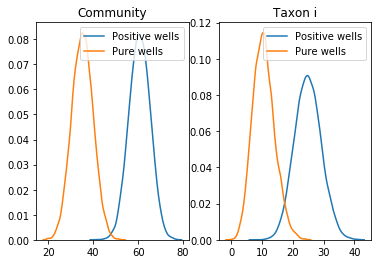

In [31]:
#@title Test your DtE Experiment here

#@markdown Here you can test how many positive and pure wells you will get with a given inoculum and viability

inoculum_size = 1 #@param {type:"slider", min:0, max:20, step:0.5}
proportion_of_taxa = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
viability = 1 #@param {type:"slider", min:0.1, max:1, step:0.1}
number_of_wells = 96 #@param {type:"integer"}
number_of_experiments = 10000 #@param {type:"integer"}

import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_dte_simple_model(inoculum_size, viability, proportion_of_taxa, num_wells=96):
    #simulate loading of the wells
    taxon_inocula = np.random.poisson(inoculum_size*proportion_of_taxa, num_wells)
    inocula=np.random.poisson(inoculum_size, num_wells)
    #simulate what happens if each has a viability of 10%
    wells = np.random.binomial(inocula, viability)
    taxon_wells = np.random.binomial(taxon_inocula, viability)

    positive_wells = np.sum(wells >=1)
    taxon_positive_wells = np.sum(taxon_wells >=1)
    pure_wells = np.sum(wells==1)
    taxon_pure_wells = np.random.poisson(pure_wells*proportion_of_taxa, 1)[0]
    return positive_wells, pure_wells, taxon_positive_wells, taxon_pure_wells



positive_wells = np.zeros(number_of_experiments)
pure_wells = np.zeros(number_of_experiments)
taxon_positive_wells = np.zeros(number_of_experiments)
taxon_pure_wells = np.zeros(number_of_experiments)
for i in tqdm.tqdm(range(number_of_experiments)):
  positive_wells[i], pure_wells[i], taxon_positive_wells[i], taxon_pure_wells[i] = calculate_dte_simple_model(inoculum_size, 
                                                                viability,
                                                                proportion_of_taxa,
                                                                num_wells=number_of_wells)


def get_CI(array_of_numbers, as_string=True, ci=95):
  median_value = np.median(array_of_numbers)
  ci_frac = (100 - ci) / 2
  percentiles = np.percentile(array_of_numbers, [ci_frac, 100 - ci_frac])
  if as_string:
    return f'{median_value:.1f} wells ({percentiles[0]:.1f}-{percentiles[1]:.1f}, 95% CI)'
  else:
    return median_value, percentiles[0], percentiles[1]
 


print(f'''
Wells per experiment: {number_of_wells}
Mean cells inoculated per well: {inoculum_size}
Number of experiments: {number_of_experiments}
Viability: {viability:.1f}

Median number of positive wells across community per experiment: {get_CI(positive_wells)}
Median number of pure wells across community per experiment: {get_CI(pure_wells)}


For taxon, i, which comprises {proportion_of_taxa*100:.1f}% of the community:

Median number of positive wells for taxon i per experiment: {get_CI(taxon_positive_wells)}
Median number of pure wells for taxon i per experiment: {get_CI(taxon_pure_wells)}

''')
fig, ax =plt.subplots(1,2)

sns.kdeplot(positive_wells, label='Positive wells', ax=ax[0]);
sns.kdeplot(pure_wells, label='Pure wells', ax=ax[0]);
sns.kdeplot(taxon_positive_wells, label='Positive wells',ax=ax[1]);
sns.kdeplot(taxon_pure_wells, label='Pure wells', ax=ax[1]);

ax[0].set_title('Community')
ax[1].set_title('Taxon i')
ax[0].legend(loc='upper right');
ax[1].legend(loc='upper right');

## Testing a simple interaction between Poisson and binomial distributions
In this simple first step, we simulate 10,000 experiments of loading 1,000 96 well plates with inocula Poisson-distributed across a range of $\overline{X_{0}}$ ranging from one to 50 cells, and viability, $V$, uniformly-distributed and ranging from zero to one.

In [0]:
import tqdm
import pandas as pd
num_replicates = 10000
viability = np.random.uniform(size=num_replicates)
mean_X0 = np.random.randint(low=1, high=50, size=num_replicates)
positive_wells = np.zeros_like(viability)
pure_wells = np.zeros_like(viability)
for i in tqdm.tqdm(range(num_replicates)):
  positive_wells[i], pure_wells[i] = calculate_dte_simple_model(mean_X0[i], viability[i], num_wells=int(96000), as_percentage=True)

df = pd.DataFrame({'inoculum':mean_X0, 
                   'viability': viability,
                   'positive_wells': positive_wells,
                   'pure_wells': pure_wells})



100%|██████████| 10000/10000 [04:14<00:00, 39.29it/s]


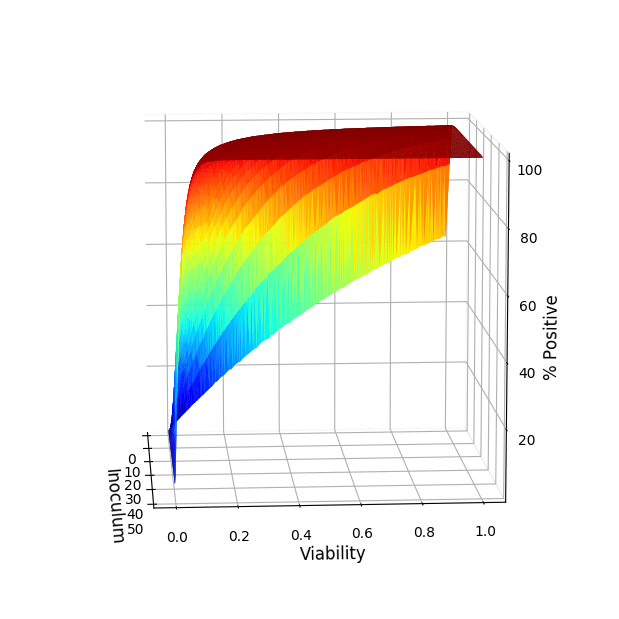

In [0]:
from matplotlib import cm
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D


# Create a figure and a 3D Axes
fig = plt.figure(figsize=[6,6], dpi=100)
ax = Axes3D(fig)
ax.set_xlabel('Inoculum', fontsize=12)
ax.set_ylabel('Viability', fontsize=12)
ax.set_zlabel('% Positive', fontsize=12)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

def init():
    # Plot the surface.
    #ax.plot_surface(df['inoculum'], df['viability'], df['positive_wells'], cmap=cm.coolwarm,
    #                   linewidth=0, antialiased=False)
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(df['inoculum'], df['viability'], df['positive_wells'], cmap=plt.cm.jet, linewidth=0.0)
    return fig,

def animate(i):
    # azimuth angle : 0 deg to 360 deg
    ax.view_init(elev=10, azim=i*4)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=90, interval=120, blit=True)

plt.rcParams['animation.html'] = 'html5'
ani


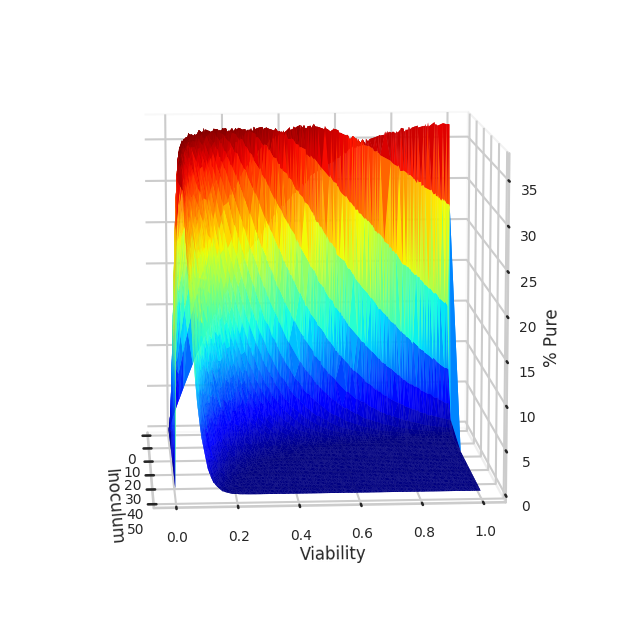

In [0]:
fig = plt.figure(figsize=[6,6], dpi=100)
ax = Axes3D(fig)
ax.set_xlabel('Inoculum', fontsize=12)
ax.set_ylabel('Viability', fontsize=12)
ax.set_zlabel('% Pure', fontsize=12)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

def init():
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(df['inoculum'], df['viability'], df['pure_wells'], cmap=plt.cm.jet, linewidth=0.0)
    return fig,

def animate(i):
    # azimuth angle : 0 deg to 360 deg
    ax.view_init(elev=10, azim=i*4)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=90, interval=120, blit=True)
plt.rcParams['animation.html'] = 'html5'
ani



In [0]:
from Bio import SeqIO

ModuleNotFoundError: ignored

In [0]:
!pip install biopython

     |████████████████████████████████| 2.2MB 2.9MB/s 
